# Adapt VQE

The goal is to perform a variational preparation of the ground state of the large-N (1,2,1) Hamiltonian

$$ H_E =  g^2 \left( N_c - \frac{1}{N_c} \right)\left[ \sum_p  P_{1,p} - \frac{1}{2}\sum_p \sum_{\hat{n}} P_{1,p} P_{1,p+\hat{n}} \right] $$

$$ H_B = -\frac{1}{\sqrt{2}g^2} \sum_{p} \left( \prod_{\hat{n}} P_{0,p+\hat{n}} \right) X_p - \frac{1}{2g^2 N_c} \sum_{p} \sum_{\hat{k}} P_{1,p+\hat{k}} \left( \prod_{\hat{n}\neq\hat{k}} P_{0,p+\hat{n}} \right) X_p $$

where $P_0 = |0\rangle\langle 0|$ and $P_1 = |1\rangle\langle 1 |$, where the sum over $\hat{n}$ is a sum over lattice unit vectors.

The algorithm of choice will be ADAPT-VQE.

### Operator pool

The pool of operators is constrained by the symmetries of the ground state and the types of interactions in the Hamiltonian. With periodic boundary conditions, the Hamiltonian is translation invariant. In addition, we must respect CP symmetry and (as a result of CPT invariance) T symmetry. Because of T symmetry, the ground state wave function should be real. We will start with the most local operators, and add increasingly non-local operators until the ansatz is expressive enough to get errors below our tolerence.

To start off with, the operator pool will be:

$$ \{ "P_0 P_0 P_0 P_0 Y", "P_0 P_0 P_0 P_1 Y" \}. $$

These operators in quotation marks are shorthand for the operators that make up the magnetic Hamiltonian, except with $X$ swapped out for $Y$ in order to make the wave function real. More operators can be added later if the performance is not good enough.

In [ ]:
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
import random

## Code for creating the Hamiltonian

In [83]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Define functions that implements the operators in the Hamiltonian.
Want to work with sparse matrices.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# Create the one-qubit operations
Id =  sparse.csc_matrix(np.array([[1.,0.],[0.,1.]]))
P1 = sparse.csc_matrix(np.array([[0., 0.],[0., 1.]]))
P0 = sparse.csc_matrix(np.array([[1.,0.],[0.,0.]]))
Xop = sparse.csc_matrix(np.array([[0.,1.],[1.,0.]]))
Yop = sparse.csc_matrix(np.array([[0.,-1.j],[1.j,0.]]))


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
A function that acts with a one-qubit operator on a specified qubit. So, it takes in a 2x2 matrix and spits out a 2^n x 2^n matrix.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def one_qubit_gate( 
    M: sparse._csc.csc_matrix, 
    p: int, 
    n: int
    ) -> sparse._csc.csc_matrix:
    if (M.shape != (2,2)):
        print('Warning: Expected M argument to be a 2x2 sparse matrix.')
    if ( p<0 or p>=n ):
        print(f'Warning: Expected p argument to be within the range [0, {n}-1] inclusive.')

    result = sparse.eye(1, format='csc') # create a sparse 1x1 matrix to store result
    for i in range(n):
        if (i==p):
            result = sparse.kron(result, M, format='csc')
        else:
            result =sparse.kron(result, Id, format='csc')  
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    Define a function that returns an n-qubit gate that is in the form of a tensor product of single qubit gates.

    Expects the dictionary op_dict to be of the form { p1: M1, p2: M2, p3: M3 } where the p's are integers specifying
    qubits and the M's are 2x2 matrices in sparse format specifying one-qubit gates.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def multi_qubit_gate(
    op_dict: dict, 
    n: int
    ) -> sparse._csc.csc_matrix:
    result = sparse.eye(1, format='csc') # Create a 1x1 in sparse format to build our operator
    for i in range(n):
        if i in op_dict:
            result =sparse.kron(result, op_dict[i], format='csc')
        else:
            result =sparse.kron(result, Id, format='csc')
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Convert between the single-index p which enumerates qubits, and double-index (i,j) which enumerates lattice sites
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def map_to_circuit( i, j, L, H ):
    if i >= L:
        print(f"[map_to_circuit] i index out of bounds: expected i<{L}, but i={i}")
    if j >= H:
        print(f"[map_to_circuit] j index out of bounds, expected j<{H}, but j={j}")
    
    return j*L + i


def map_to_lattice( p, L, H ):
    if p >= (L*H):
        print(f"[map_to_lattice] p index out of bounds, expected p<{L*H}, but p={p}")

    return p % L, p // L

# A function that applies the specified operator to every qubit in the lattice, and then returns the resulting matrix
def sigma(op_name, lat_shape, boundary='periodic'):
    L = lat_shape[0]
    H = lat_shape[1]
    n = L*H

    op = sparse.csc_matrix((2**n, 2**n))

    if boundary == "periodic":

        if op_name == "P1":
            for p in range(n):
                op += one_qubit_gate(P1, p, n)

        elif op_name == "P1P1":
            for p in range(n):
                i, j = map_to_lattice(p, L, H)
                nr   = map_to_circuit((i + 1) % L, j, L, H)
                nu   = map_to_circuit(i, (j + 1) % H, L, H)
                op = multi_qubit_gate( {p: P1, nr: P1}, n )
                op = multi_qubit_gate( {p: P1, nu: P1}, n )

        elif op_name == "P0P0P0P0X":
            for p in range(n):
                i, j = map_to_lattice(p, L, H)
                nl   = map_to_circuit((i - 1) % L, j, L, H)
                nd   = map_to_circuit(i, (j - 1) % H, L, H)
                nr   = map_to_circuit((i + 1) % L, j, L, H)
                nu   = map_to_circuit(i, (j + 1) % H, L, H)
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P0}, n )

        elif op_name == "P0P0P0P1X":
            for p in range(n):
                i, j = map_to_lattice(p, L, H)
                nl   = map_to_circuit((i - 1) % L, j, L, H)
                nd   = map_to_circuit(i, (j - 1) % H, L, H)
                nr   = map_to_circuit((i + 1) % L, j, L, H)
                nu   = map_to_circuit(i, (j + 1) % H, L, H)
                op += multi_qubit_gate( {p: Xop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P1}, n )
        
        elif op_name == "P0P0P0P0Y":
            for p in range(n):
                i, j = map_to_lattice(p, L, H)
                nl   = map_to_circuit((i - 1) % L, j, L, H)
                nd   = map_to_circuit(i, (j - 1) % H, L, H)
                nr   = map_to_circuit((i + 1) % L, j, L, H)
                nu   = map_to_circuit(i, (j + 1) % H, L, H)
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P0, nu: P0}, n )
        
        elif op_name == "P0P0P0P1Y":
            for p in range(n):
                i, j = map_to_lattice(p, L, H)
                nl   = map_to_circuit((i - 1) % L, j, L, H)
                nd   = map_to_circuit(i, (j - 1) % H, L, H)
                nr   = map_to_circuit((i + 1) % L, j, L, H)
                nu   = map_to_circuit(i, (j + 1) % H, L, H)
                op += multi_qubit_gate( {p: Yop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P0, nu: P1}, n )
        else:
            raise ValueError(f"Unknown operator name: {op_name}")
    
    elif boundary == "open":
        raise NotImplementedError("Open boundary conditions not implemented yet.")
    
    return op

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' 
Create a function that produces the Hamiltonian matrix
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def make_electric_ham(
    g: float, 
    lat_shape: list, 
    boundary: str = 'periodic', 
    N_colors: int = 3 
) -> sparse._csc.csc_matrix:
    
    # Returns a sparse 2**n x 2**n matrix containing the diagonal part of the Hamiltonian
    H_E = sigma('P1', lat_shape, boundary)
    H_E -= 0.5 * sigma('P1P1', lat_shape, boundary)
        
    return (N_colors - 1/N_colors)*g*g * H_E



def make_magnetic_ham(
    g: float, 
    lat_shape: tuple, 
    boundary='periodic',
    N_colors: int = 3
) -> sparse._csc.csc_matrix:
    
    # Returns a sparse 2**n x 2**n matrix containing the magnetic part of the Hamiltonian
    coeff1 = -np.sqrt(2)/(2*g*g)
    coeff2 = -1/(2*g*g*N_colors)

    H_B1 = sigma('P0P0P0P0X', lat_shape, boundary)
    H_B2 = sigma('P0P0P0P1X', lat_shape, boundary)

    H_B = coeff1 * H_B1  +   coeff2 * H_B2
    
    return H_B


def make_ham(
    g: float, 
    lat_shape: tuple, 
    boundary: str ='periodic',
    N_colors: int =3
) -> sparse._csc.csc_matrix:
    
    HE = make_electric_ham(g, lat_shape, boundary, N_colors)
    HB = make_magnetic_ham(g, lat_shape, boundary, N_colors)
    return HE + HB


def get_ground_state_energy(g, lat_shape, boundary='periodic', N_colors=3):
    H = make_ham(g, lat_shape, boundary, N_colors)
    evals, evecs = sparse.linalg.eigsh( H, which='SA', k=1)
    return evals[0]


## Ground state prep

In [84]:
def get_operator_pool(op_names, lat_shape, boundary="periodic"):
    op_pool = [sigma(op_name, lat_shape, boundary) for op_name in op_names]
    return op_pool

In [85]:
g = 1.
lat_shape = (3,3)

In [86]:
operator_pool = [sigma("P0P0P0P0Y", lat_shape), sigma("P0P0P0P1Y", lat_shape)]

In [87]:
imag_operator_pool = [op.imag for op in operator_pool]

In [88]:
H = make_ham(g, lat_shape)
H = H.real

In [89]:
commutator_pool = [-(H @ op - op @ H) for op in imag_operator_pool]

In [90]:
def construct_electric_vac(lat_shape):
    n = lat_shape[0]*lat_shape[1]
    return sparse.csc_matrix( ([1] + [0]*(2**n - 1)) ).T

In [91]:
electric_vac = construct_electric_vac(lat_shape)

In [92]:
def expectation_value(state, op):
    return (state.T.conj() @ (op @ state)).sum().real

In [93]:
ips = np.array([expectation_value(electric_vac, op) for op in commutator_pool])

In [94]:
min_op = imag_operator_pool[random.choice(np.where(ips == np.max(np.abs(ips)))[0])] 

In [ ]:
eps_vals = np.linspace(0, 1, 100)
energies = []

for i, eps in enumerate(eps_vals):
    U = sp.sparse.linalg.expm( min_op * eps )
    new_state = U @ electric_vac
    energies.append( expectation_value(new_state, H) )

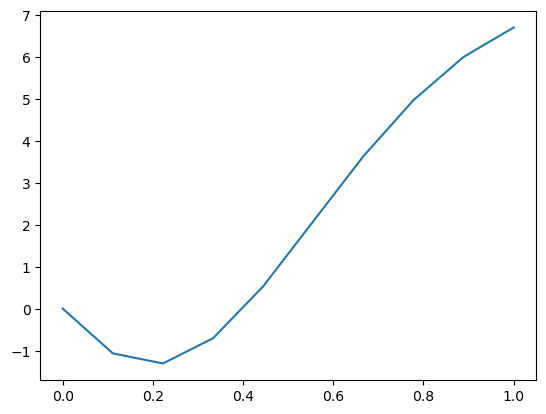

In [96]:
# plot the energies
plt.plot(eps_vals, energies)

In [ ]:
def objective_function(eps):
    U = sp.sparse.linalg.expm( min_op * eps[0] )
    new_state = U @ electric_vac
    return expectation_value(new_state, H)

eps0 = [0]

sol = sp.optimize.minimize(objective_function, eps0)

In [144]:
sol

      fun: -1.329970043327021
 hess_inv: array([[0.01402168]])
      jac: array([1.78813934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.19690846])

## ADAPT-VQE Algorithm

In [121]:
'''Helper functions'''


# These ones only require lattice size information

def get_operator_pool(op_names, lat_shape, boundary="periodic"):
    op_pool = [sigma(op_name, lat_shape, boundary) for op_name in op_names]
    return op_pool

def get_imag_operator_pool(op_names, lat_shape, boundary="periodic"):
    operator_pool = get_operator_pool(op_names, lat_shape, boundary)
    return [op.imag for op in operator_pool]

def construct_electric_vac(lat_shape):
    n = lat_shape[0]*lat_shape[1]
    return sparse.csc_matrix( ([1] + [0]*(2**n - 1)) ).T

def expectation_value(state, op):
    return (state.T.conj() @ (op @ state)).sum().real

# These ones require the coupling / hamiltonian

def get_commutator_pool(H, imag_operator_pool):
    return [-(H @ op - op @ H) for op in imag_operator_pool]


In [ ]:
def opt_step(psi_prev, epss_prev, indices_prev, H, lat_shape, commutator_pool, psi_0, imag_operator_pool):
    n = lat_shape[0]*lat_shape[1]

    ips = np.array([expectation_value(psi_prev, op) for op in commutator_pool])
    min_index = random.choice(np.where(ips == np.max(np.abs(ips)))[0])
    new_indices = np.append( indices_prev.astype(int), int(min_index) )
    new_epss = np.append(epss_prev, 0.01)

    def ansatz(epss):
        U = sp.sparse.eye(2**n, format="csc")
        for eps, idx in zip(epss, new_indices):
            U = sp.sparse.linalg.expm( eps * imag_operator_pool[idx]) @ U
        return U @ psi_0
    
    def objective_ev(epss):
        new_state = ansatz(epss)
        return expectation_value(new_state, H)
    
    sol = sp.optimize.minimize(objective_ev, new_epss)
    opt_epss = sol["x"]
    new_energy = sol["fun"]
    new_state = ansatz(opt_epss)

    return new_indices, new_state, opt_epss, new_energy

In [141]:
def adapt_vqe(g, lat_shape, boundary="periodic", N_colors=3, op_pool_names=["P0P0P0P0Y", "P0P0P0P1Y"], delta_E=0.0001):

    H = make_ham(g, lat_shape, boundary, N_colors)
    imag_operator_pool = get_imag_operator_pool(op_pool_names, lat_shape, boundary)
    commutator_pool = get_commutator_pool(H, imag_operator_pool)

    # store results
    psi_0 = construct_electric_vac(lat_shape)
    epss = []
    indices = []
    energies = []

    # use in loop
    new_state = psi_0
    opt_epss = np.array(epss)
    new_indices = np.array(indices)

    while True:
        new_indices, new_state, opt_epss, new_energy = opt_step(new_state, opt_epss, new_indices, H, lat_shape, commutator_pool, psi_0, imag_operator_pool)
        indices.append( new_indices[-1] )
        epss.append( opt_epss )
        energies.append( new_energy )
        if len(energies) > 2 and abs(energies[-1] - energies[-2]) <= delta_E:
            break
    
    return energies, indices, epss, new_state

In [145]:
'''
input data
'''
g = 0.6
lat_shape = (3,3)
boundary="periodic"
N_colors = 3


'''
hyper-parameters
'''
op_pool =["P0P0P0P0Y", "P0P0P0P1Y"]
delta_E = 0.001


energies, indices, epss, new_state = adapt_vqe(g, lat_shape, boundary, N_colors, op_pool, delta_E)

In [146]:
energies[-1] - get_ground_state_energy(g, lat_shape)

0.05291449437232831

### Performance vs. coupling